## 狗品种识别

In [2]:
import pandas as pd
import os
from d2l import torch as d2l
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_dir = '../data/dog-breed-identification'
labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
# labels

- 整理品种识别数据集

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

- 图像增广

In [4]:
batch_size = 32
normalize = T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    T.ToTensor(),
    normalize
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize
])

- 加载数据

In [5]:
train_ds, train_valid_ds = [ImageFolder(root=os.path.join(data_dir, 'train_valid_test', folder),
                                        transform=train_transform) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [ImageFolder(root=os.path.join(data_dir, 'train_valid_test', folder),
                    transform=test_transform) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
                                for dataset in [train_ds, train_valid_ds]]
valid_iter, test_iter = [DataLoader(dataset, batch_size, shuffle=False, drop_last=False)
                        for dataset in [valid_ds, test_ds]]
for X, y in train_iter:
    # print(X)
    print(y.shape)
    break

torch.Size([32])


- 获取预训练模型

In [6]:
def get_net(devices, frozen=True):
    net = nn.Sequential()
    net.features = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(),
                               nn.Linear(256, 120))
    net = net.to(device=devices[0])
    if frozen:
        for param in net.features.parameters():
            param.requires_grad = False
    return net

- 定义损失函数

In [7]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0.0
    for X, y in data_iter:
        X, y = X.to(devices[0]), y.to(devices[0])
        outputs = net(X)
        l = loss(outputs, y)
        l_sum += l.sum()
        n += y.numel()
    return (l_sum / n).to('cpu')


- 定义训练函数

In [8]:
def train_multi_gpu(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay, frozen=True):
    net = nn.DataParallel(net, devices).to(devices[0])
    if frozen:
        trainer = torch.optim.AdamW((param for param in net.parameters() if param.requires_grad),
                                    lr=lr, weight_decay=wd)
    else:
        trainer = torch.optim.AdamW(
            [{'params': net.module.features.parameters()}, {'params': net.module.output_new.parameters(), 'lr': lr * 10}],
            lr=lr,weight_decay=wd
        )
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator('epoch', xlim=[1, num_epochs], legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures, f'\n {metric[1] * num_epochs / timer.sum():.1f}examples/sec on {str(devices)}')


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_multi_gpu2(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay, frozen=True):
    if len(devices) > 1:
        net = nn.DataParallel(net, devices).to(devices[0])
    
    # 选择合适的优化器
    if frozen:
        trainer = optim.AdamW((param for param in net.parameters() if param.requires_grad),
                              lr=lr, weight_decay=wd)
    else:
        trainer = optim.AdamW(
            [{'params': net.module.features.parameters()}, 
             {'params': net.module.output_new.parameters(), 'lr': lr * 10}],
            lr=lr, weight_decay=wd
        )

    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)

    num_batches = len(train_iter)
    train_losses, valid_losses = [], []  # 用于存储损失值

    for epoch in range(num_epochs):
        net.train()
        total_train_loss, total_samples = 0.0, 0

        for i, (features, labels) in enumerate(train_iter):
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()

            total_train_loss += l.item()
            total_samples += labels.shape[0]

            # 记录 train loss
            if i % (num_batches // 5) == 0 or i == num_batches - 1:
                avg_train_loss = total_train_loss / total_samples
                print(f"Epoch {epoch + 1}, Iter {i}: Train Loss = {avg_train_loss:.4f}")

        # 计算 epoch 级别的平均 train loss
        avg_train_loss = total_train_loss / total_samples
        train_losses.append(avg_train_loss)

        # 计算 valid loss
        if valid_iter is not None:
            net.eval()
            total_valid_loss, total_valid_samples = 0.0, 0

            with torch.no_grad():
                for features, labels in valid_iter:
                    features, labels = features.to(devices[0]), labels.to(devices[0])
                    output = net(features)
                    l = loss(output, labels).sum()

                    total_valid_loss += l.item()
                    total_valid_samples += labels.shape[0]

            avg_valid_loss = total_valid_loss / total_valid_samples
            valid_losses.append(avg_valid_loss)
            print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Valid Loss = {avg_valid_loss:.4f}")
        else:
            valid_losses.append(None)  # 记录 None 以保持列表对齐
        
        scheduler.step()

    # **绘制 Loss 曲线**
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    if valid_iter is not None:
        plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss', marker='s')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()


- 训练

Epoch 1, Iter 0: Train Loss = 4.8265
Epoch 1, Iter 59: Train Loss = 4.7459
Epoch 1, Iter 118: Train Loss = 4.6600
Epoch 1, Iter 177: Train Loss = 4.5258
Epoch 1, Iter 236: Train Loss = 4.2990
Epoch 1, Iter 295: Train Loss = 4.0135
Epoch 1: Train Loss = 4.0135, Valid Loss = 1.8909
Epoch 2, Iter 0: Train Loss = 2.6246
Epoch 2, Iter 59: Train Loss = 2.2584
Epoch 2, Iter 118: Train Loss = 2.0912
Epoch 2, Iter 177: Train Loss = 1.9952
Epoch 2, Iter 236: Train Loss = 1.9136
Epoch 2, Iter 295: Train Loss = 1.8395
Epoch 2: Train Loss = 1.8395, Valid Loss = 0.7177
Epoch 3, Iter 0: Train Loss = 1.7185
Epoch 3, Iter 59: Train Loss = 1.4998
Epoch 3, Iter 118: Train Loss = 1.4542
Epoch 3, Iter 177: Train Loss = 1.4049
Epoch 3, Iter 236: Train Loss = 1.3939
Epoch 3, Iter 295: Train Loss = 1.3755
Epoch 3: Train Loss = 1.3755, Valid Loss = 0.5353
Epoch 4, Iter 0: Train Loss = 1.5016
Epoch 4, Iter 59: Train Loss = 1.2454
Epoch 4, Iter 118: Train Loss = 1.2510
Epoch 4, Iter 177: Train Loss = 1.2346
Epoc

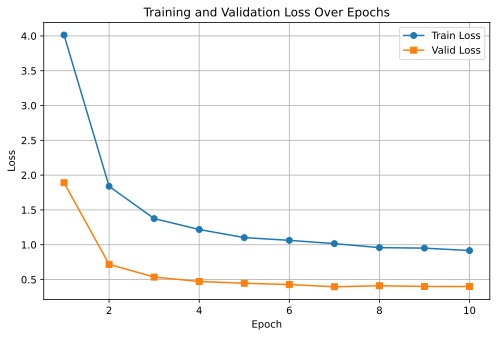

In [72]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-5, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices, frozen=False)
train_multi_gpu2(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay, frozen=False)

Epoch 1, Iter 0: Train Loss = 0.4957
Epoch 1, Iter 63: Train Loss = 0.9373
Epoch 1, Iter 126: Train Loss = 0.9257
Epoch 1, Iter 189: Train Loss = 0.9435
Epoch 1, Iter 252: Train Loss = 0.9383
Epoch 1, Iter 315: Train Loss = 0.9387
Epoch 1, Iter 318: Train Loss = 0.9389
Epoch 2, Iter 0: Train Loss = 0.9229
Epoch 2, Iter 63: Train Loss = 0.9080
Epoch 2, Iter 126: Train Loss = 0.8770
Epoch 2, Iter 189: Train Loss = 0.8835
Epoch 2, Iter 252: Train Loss = 0.9014
Epoch 2, Iter 315: Train Loss = 0.8855
Epoch 2, Iter 318: Train Loss = 0.8878
Epoch 3, Iter 0: Train Loss = 0.6442
Epoch 3, Iter 63: Train Loss = 0.8781
Epoch 3, Iter 126: Train Loss = 0.8600
Epoch 3, Iter 189: Train Loss = 0.8622
Epoch 3, Iter 252: Train Loss = 0.8624
Epoch 3, Iter 315: Train Loss = 0.8643
Epoch 3, Iter 318: Train Loss = 0.8630
Epoch 4, Iter 0: Train Loss = 1.1460
Epoch 4, Iter 63: Train Loss = 0.8665
Epoch 4, Iter 126: Train Loss = 0.8543
Epoch 4, Iter 189: Train Loss = 0.8674
Epoch 4, Iter 252: Train Loss = 0.869

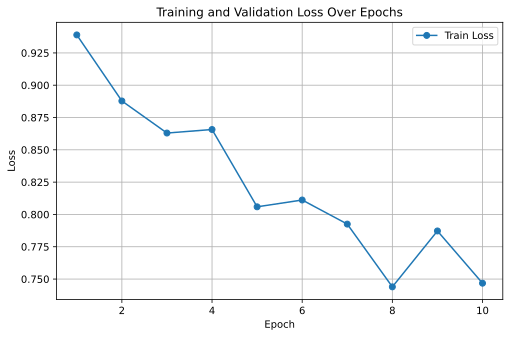

In [73]:
train_multi_gpu2(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay, frozen=False)

In [75]:
torch.save(net, '../checkpoints/dog/R50_dog.pth')
torch.save(net.state_dict(), '../checkpoints/dog/R50_weight_dog.pth')

In [11]:
net = torch.load('../checkpoints/dog/R50_dog.pth')
devices = d2l.try_all_gpus()
preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())

In [20]:
# preds[0], preds[1]
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test','unknown')))
with open('./submission_dog.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')
